<a href="https://colab.research.google.com/github/CzupikJakub/predictive-maintenance-rul/blob/main/turbofan_rul_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Turbofan RUL  🚀

This single notebook trains a **Remaining Useful Life (RUL)** baseline model for rotating equipment.
- **Runs instantly** on a **synthetic dataset**.
- Saves model and metrics locally.


In [13]:

# Config
USE_CMAPSS = True
RANDOM_STATE = 42


In [14]:
import os
os.makedirs("data", exist_ok=True)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:

import os, json, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib

warnings.filterwarnings("ignore")
np.random.seed(RANDOM_STATE)

ART_DIR = Path("./artifacts")
ART_DIR.mkdir(parents=True, exist_ok=True)


## Load CMAPSS if available, else synthesize

In [18]:

def load_cmapss_fd001():
    train_fp = Path("./train_FD001.txt")
    test_fp  = Path("./test_FD001.txt")
    rul_fp   = Path("./RUL_FD001.txt")
    if not (train_fp.exists() and test_fp.exists() and rul_fp.exists() and USE_CMAPSS):
        return None, None, None

    def read_df(fp):
        df = pd.read_csv(fp, sep="\s+", header=None)
        if df.shape[1] > 26:
            df = df.iloc[:, :26]
        df.columns = (["engine_id", "cycle"] +
                      [f"op{i}" for i in range(1,4)] +
                      [f"sensor{i}" for i in range(1,22)])
        return df

    train_df = read_df(train_fp)
    test_df  = read_df(test_fp)
    rul_df   = pd.read_csv(rul_fp, header=None, names=["RUL"])
    return train_df, test_df, rul_df

def make_synthetic_dataset(n_engines=80, min_cycles=120, max_cycles=220, n_sensors=6):
    rows = []
    for eid in range(1, n_engines+1):
        total = np.random.randint(min_cycles, max_cycles+1)
        for c in range(1, total+1):
            sensors = []
            for s in range(n_sensors):
                base = 50 + 10*s
                trend = (c / total) * (5 + s)
                noise = np.random.normal(0, 0.8)
                sensors.append(base + trend + noise)
            rows.append([eid, c] + sensors + [total - c])
    cols = ["engine_id", "cycle"] + [f"sensor{i}" for i in range(1, n_sensors+1)] + ["RUL"]
    df = pd.DataFrame(rows, columns=cols)
    return df

train_df, test_df, rul_df = load_cmapss_fd001()
mode = "CMAPSS" if train_df is not None else "SYNTH"
print("DATA MODE:", mode)

if mode == "SYNTH":
    df = make_synthetic_dataset()
else:
    def label_rul(d):
        max_c = d["cycle"].max()
        d = d.copy()
        d["RUL"] = max_c - d["cycle"]
        return d
    df = train_df.groupby("engine_id").apply(label_rul).reset_index(drop=True)

df.head()


DATA MODE: SYNTH


,engine_id,cycle,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,RUL
0,1,1,49.139736,60.290209,70.264169,80.855196,89.587929,99.638344,170
1,1,2,49.601375,59.330909,67.991832,80.853863,90.758419,98.897858,169
2,1,3,49.745282,59.511338,69.560132,78.428654,89.654315,100.653615,168
3,1,4,52.164549,60.455737,70.261518,79.774786,89.730323,100.991870,167
4,1,5,50.379026,59.666991,69.387437,80.104514,89.836239,100.287975,166


## Feature engineering

In [19]:

def add_rolling_features(df, sensor_cols, by="engine_id", window=5):
    df = df.sort_values([by, "cycle"]).copy()
    for col in sensor_cols:
        df[f"{col}_roll_mean"] = df.groupby(by)[col].transform(lambda s: s.rolling(window, min_periods=1).mean())
        df[f"{col}_roll_std"]  = df.groupby(by)[col].transform(lambda s: s.rolling(window, min_periods=1).std().fillna(0))
        df[f"{col}_diff"]      = df.groupby(by)[col].diff().fillna(0)
    return df

sensor_cols = [c for c in df.columns if c.startswith("sensor")]
df_feat = add_rolling_features(df, sensor_cols, window=5)
feature_cols = [c for c in df_feat.columns if c.startswith("sensor")]
target_col = "RUL"

df_feat.head()


,engine_id,cycle,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,RUL,sensor1_roll_mean,...,sensor3_diff,sensor4_roll_mean,sensor4_roll_std,sensor4_diff,sensor5_roll_mean,sensor5_roll_std,sensor5_diff,sensor6_roll_mean,sensor6_roll_std,sensor6_diff
0,1,1,49.139736,60.290209,70.264169,80.855196,89.587929,99.638344,170,49.139736,...,0.000000,80.855196,0.000000,0.000000,89.587929,0.000000,0.000000,99.638344,0.000000,0.000000
1,1,2,49.601375,59.330909,67.991832,80.853863,90.758419,98.897858,169,49.370556,...,-2.272337,80.854529,0.000942,-0.001333,90.173174,0.827662,1.170490,99.268101,0.523602,-0.740485
2,1,3,49.745282,59.511338,69.560132,78.428654,89.654315,100.653615,168,49.495465,...,1.568300,80.045904,1.400580,-2.425209,90.000221,0.657457,-1.104104,99.729939,0.881455,1.755757
3,1,4,52.164549,60.455737,70.261518,79.774786,89.730323,100.991870,167,50.162736,...,0.701386,79.978125,1.151575,1.346132,89.932747,0.553514,0.076008,100.045422,0.957127,0.338255
4,1,5,50.379026,59.666991,69.387437,80.104514,89.836239,100.287975,166,50.205994,...,-0.874081,80.003403,0.998894,0.329728,89.913445,0.481296,0.105916,100.093932,0.835964,-0.703895


## Train / validation split by engine

In [20]:

engines = df_feat["engine_id"].unique()
train_eng, val_eng = train_test_split(engines, test_size=0.2, random_state=RANDOM_STATE)
train_data = df_feat[df_feat["engine_id"].isin(train_eng)]
val_data   = df_feat[df_feat["engine_id"].isin(val_eng)]

X_train = train_data[feature_cols].values
y_train = train_data[target_col].values
X_val   = val_data[feature_cols].values
y_val   = val_data[target_col].values

len(train_eng), len(val_eng)


(64, 16)

## Train baseline model and save artifacts

In [21]:

model = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("rf", RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))
])
model.fit(X_train, y_train)

preds = model.predict(X_val)
mse = mean_squared_error(y_val, preds)
rmse = mse ** 0.5
mae  = mean_absolute_error(y_val, preds)
metrics = {"rmse": float(rmse), "mae": float(mae)}
print("Metrics:", metrics)

import joblib, json
joblib.dump(model, ART_DIR / "model.joblib")
with open(ART_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)


Metrics: {'rmse': 18.602964052233588, 'mae': 14.036832892998678}


## Plot: True vs Predicted RUL

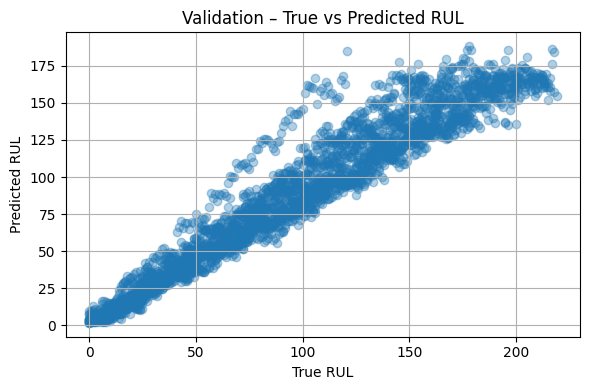

In [25]:
import matplotlib.pyplot as plt
import pathlib
pathlib.Path("figures").mkdir(exist_ok=True)
plt.figure(figsize=(6,4))
plt.scatter(y_val, preds, alpha=0.35)
plt.xlabel("True RUL"); plt.ylabel("Predicted RUL"); plt.title("Validation – True vs Predicted RUL")
plt.grid(True); plt.tight_layout()
plt.savefig("figures/rul_scatter.png", dpi=160)


## Inference: latest record per engine

In [26]:

def latest_per_engine(df_feat):
    return df_feat.sort_values(["engine_id", "cycle"]).groupby("engine_id").tail(1)

latest = latest_per_engine(val_data)
X_latest = latest[feature_cols].values
latest_preds = model.predict(X_latest)
out = latest[["engine_id", "RUL"]].copy()
out["pred_RUL"] = latest_preds
out = out.sort_values("engine_id").reset_index(drop=True)
out.head()


,engine_id,RUL,pred_RUL
0,1,0,2.460000
1,5,0,2.093333
2,11,0,3.713333
3,13,0,9.740000
4,19,0,1.613333
